In [201]:
import pymc3 as pm
import numpy as np
import sqlite3, os
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import re
import pickle

from matplotlib.patches import Ellipse
import theano.tensor as tt
from theano.tensor.nlinalg import det, matrix_inverse
#Gaussian Mixture Model! Now to multivariateness!
# execfile('Imports.py')
# import Modules.Funcs as funcs
%matplotlib inline

pd.set_option('precision', 2)
#Fetch pooled data


# import raw-ish data
con = sqlite3.connect('../data/experiment.db')
info = pd.read_sql_query("SELECT * from participants", con)
df = pd.read_sql_query("SELECT * from generation", con)
alphas = pd.read_sql_query("SELECT * from alphas", con)
stimuli = pd.read_sql_query("SELECT * from stimuli", con).values

con.close()

savedir = './'
gentypeStr = ['N','B','C'] #not alpha, only beta, beta-gamma
gentypeStrDisp = ['A\'','B','C'] #not alpha, only beta, beta-gamma
conditionLabels = ['Bottom','Middle']
gentypeCols = [[.3,0,.5],[0,0,.5],[0,.5,0]]
pooled_alphas = dict()#np.empty((0, 2))
pooled_gen  = dict()#np.empty((0, 2))
ind_alphas = dict()
ind_gen = dict()
cond_all = []
data = dict()

# f, ax= plt.subplots(2,3, figsize=(8, 6))
alpha = .1
jittersd = .00
for i, row in info.iterrows():
    pid, condition, gentype = int(row.participant), row.condition, row.gentype
    pdf = df.loc[df.participant==pid]
    condNum = conditionLabels.index(condition)
    gentypeStr_p = gentypeStr[gentype]
    #condInd = condNum*3+gentype #condition index
    condName = condition + gentypeStr_p
    palphas = alphas[condition]
    pgen = df.stimulus[df.participant == pid]
    if gentype==2:
        betastr = [gentypeStrDisp[1] if pdf_row.category=='Beta' else gentypeStrDisp[2] for ii,pdf_row in pdf.iterrows() ]
        betacol = [gentypeCols[1] if pdf_row.category=='Beta' else gentypeCols[2] for ii,pdf_row in pdf.iterrows() ]
        pbetas = pdf.stimulus[df.category == 'Beta']
        pgammas = pdf.stimulus[df.category == 'Gamma']
        stackc = stimuli[pgammas.values]
    else:
        pbetas = df.stimulus[df.participant == pid]#pdf.stimulus[df.category == 'Beta']    
        betastr = gentypeStrDisp[gentype]
        betacol = gentypeCols[gentype]
        
    #stack data
    stacka = stimuli[palphas.values] 
    stackb = stimuli[pbetas.values]
    stackgen = stimuli[pgen.values]
    #Funnel data into appropriate separate conditions
    if not condName in pooled_alphas.keys():
        pooled_alphas[condName] = np.empty((0,2))
        pooled_gen[condName]  = np.empty((0,2))
        ind_alphas[condName] = dict({pid:np.empty((0,2))})
        ind_gen[condName] = dict({pid:np.empty((0,2))})
        data[condName] = dict()
        cond_all += [condName]

    if not pid in data[condName].keys():
        data[condName][pid] = dict({0:dict(),1:dict()})
       
    pooled_alphas[condName] = np.concatenate((pooled_alphas[condName],stacka), axis=0)
    pooled_gen[condName] = np.concatenate((pooled_gen[condName],stackgen), axis=0)
    
    ind_alphas[condName][pid] = stacka
    ind_gen[condName][pid] = stackgen
    
    data[condName][pid][0]['vals'] = stacka
    data[condName][pid][1]['vals'] = stackb
    if gentype==2:
        data[condName][pid][2] = dict()
        data[condName][pid][2]['vals'] = stackc
    for dd in data[condName][pid]:
        data[condName][pid][dd]['cov'] = np.cov(data[condName][pid][dd]['vals'],rowvar=False)


    #jitter data for plotting
    stacka_plot = stacka + np.random.normal(0,jittersd,size=stacka.shape)
    stackgen_plot = stackgen + np.random.normal(0,jittersd,size=stackgen.shape)

In [202]:
cov_mean = dict()
cond_all = np.unique(cond_all)
# plt.scatter(d['vals'][:,0],d['vals'][:,1])
for cn in data.keys():    
    if cn[-1]=='C':
        groups = 3
    else:
        groups = 2
    cov_mean[cn] = dict()
    for gg in range(1,groups):
        cov = np.zeros((2,2))#np.empty((2,2,1))#np.zeros((2,2))
        ncov = len(list(data[cn].keys()))
        for pid in data[cn].keys():
            d = data[cn][pid][gg]['cov']
            if np.isnan(d[0,0]):
                d = np.zeros((2,2))
            cov += d #np.stack((cov,data[cn][pid][gg]['cov']),axis=2)#np.stack((cov,np.expand_dims(data[cn][pid][gg]['cov'],axis=2)),axis=2)
        cov_mean[cn][gg] = cov/ncov

# print(d['cov'])
# print(d)
# print(np.cov(d, rowvar=False))


In [244]:
allval

array([[ 0.875,  0.625],
       [ 0.875,  0.875],
       [ 0.625,  0.625],
       [ 0.625,  0.875],
       [-1.5  , -1.   ],
       [-2.   , -1.   ],
       [ 0.   , -1.   ],
       [-0.75 , -1.   ],
       [ 0.   ,  0.   ],
       [ 0.   , -2.   ],
       [ 0.   , -0.75 ],
       [-2.   ,  0.   ],
       [ 0.5  , -1.25 ],
       [ 0.75 , -1.5  ],
       [ 0.25 , -0.5  ],
       [ 0.75 , -0.5  ],
       [-2.   , -1.   ],
       [ 0.   , -1.   ],
       [-1.5  , -1.   ],
       [-0.5  , -1.   ],
       [-0.5  , -0.375],
       [-0.75 , -0.375],
       [-0.25 , -1.625],
       [-0.5  , -1.375],
       [-0.25 , -0.75 ],
       [ 0.   , -0.75 ],
       [ 0.5  , -0.75 ],
       [-0.5  , -0.75 ],
       [-2.   , -2.   ],
       [-2.   ,  0.   ],
       [ 0.   , -2.   ],
       [ 0.   ,  0.   ],
       [-2.   , -1.   ],
       [ 0.   , -1.   ],
       [-0.5  , -1.   ],
       [-1.25 , -1.   ],
       [ 0.125, -0.75 ],
       [ 0.125, -1.   ],
       [-1.625, -0.5  ],
       [-1.625, -1.   ],


In [203]:
temp = np.ones((2,6))
for it,t in enumerate(temp):
    print(t)

[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]


BottomB
[[0.33658854 0.03924851]
 [0.03924851 0.40811012]]
BottomC
[[0.40587798 0.0014881 ]
 [0.0014881  0.09821429]]
[[0.23400298 0.00483631]
 [0.00483631 0.08184524]]
BottomN
[[ 0.54945959 -0.03336466]
 [-0.03336466  0.43697133]]
MiddleB
[[ 0.33746476 -0.03430451]
 [-0.03430451  0.34369126]]
MiddleC
[[0.41282895 0.02658991]
 [0.02658991 0.43804825]]
[[ 0.42160088 -0.05098684]
 [-0.05098684  0.21737939]]
MiddleN
[[0.52598852 0.00775935]
 [0.00775935 0.5305591 ]]


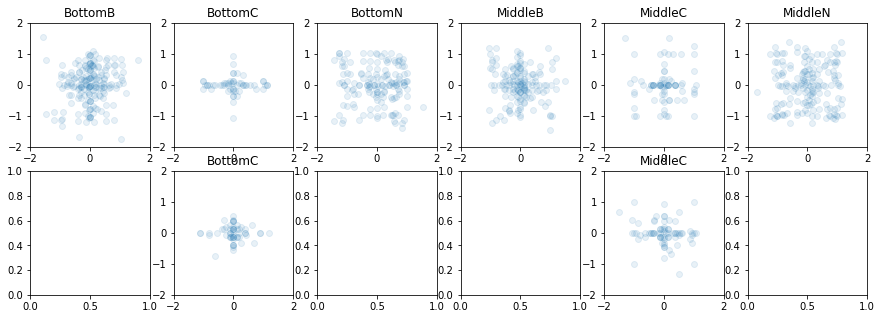

In [247]:
for i in np.unique(list(cov_mean.keys())):
    print(i)
    print(cov_mean[i][1])
    if i[-1]=='C':
        print(cov_mean[i][2])
        
lim=2
fig,axs = plt.subplots(2,6,figsize=(15,5))
for i, ax_row in enumerate(axs):
    for ii,cn in enumerate(cond_all):
        if cn[-1]!='C' and i>0:
            continue
        ax = ax_row[ii]
        allval = np.empty((0,2))
        for pid in data[cn].keys():
            dd = data[cn][pid][i+1]['vals'] 
            center = np.mean(dd,axis=0)#(np.max(dd,axis=0)-np.min(dd,axis=0))/2
            #centre data
            d = dd-center#np.mean(dd,axis=0)
            allval = np.concatenate((allval,d))
        ax.scatter(allval[:,0],allval[:,1],alpha=.1)
        ax.set_ylim(-lim,lim)
        ax.set_xlim(-lim,lim)
        ax.set_title(cn)

In [205]:
import seaborn as sns
def plot_ellipse(ax,ms,ss):
    colors = sns.color_palette()
    k = ms.shape[0]
    for i in range(k):
        colr = colors[i]
        colr='Blue'
        var, U = np.linalg.eig(ss[i])
#         print U
#         print np.arccos(np.abs(U[0, 0]))
        angle = 180. / np.pi * np.arccos(np.abs(U[0, 0])) #* np.sign(ss[i][1,0])
#         print(var)
#         print(angle)
        #Set the angle right
        if (var[0]>var[1] and ss[i][1,0]<0) or (var[1]>var[0] and ss[i][1,0]>0):
            angle = -angle
#         angle=0
        e = Ellipse(ms[i,:], 2 * np.sqrt(5.991 * var[0]),
                    2 * np.sqrt(5.991 * var[1]),
                    angle=angle)
        e.set_alpha(0.05)
        e.set_facecolor(colr)
        e.set_zorder(10);
        ax.add_artist(e);
#         ax.scatter(ms[:,0],ms[:,1],c=colr,alpha=.2)

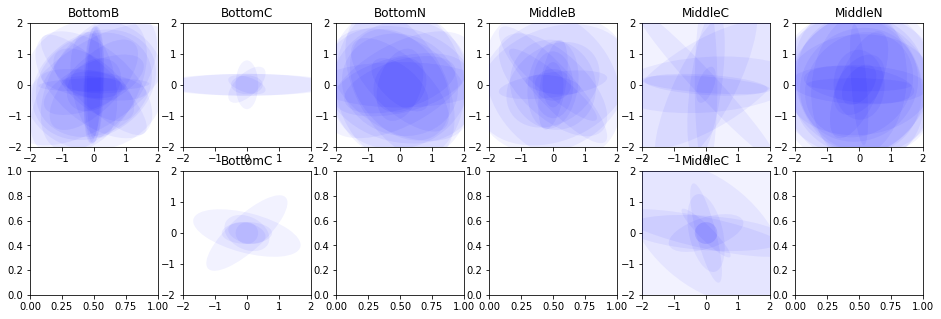

In [206]:
#Ellipses?
means = np.zeros((1,2))
f, axs= plt.subplots(2,6, figsize=(16, 5))
for i, ax_row in enumerate(axs):
    for ii,cn in enumerate(cond_all):
        if cn[-1]!='C' and i>0:
            continue
        ax = ax_row[ii]
        for pid in data[cn].keys():
            ss = data[cn][pid][i+1]['cov'] 
            plot_ellipse(ax,means,[ss])
        ax.set_ylim(-lim,lim)
        ax.set_xlim(-lim,lim)
        ax.set_title(cn)
        

{'DispersedP': 20, 'DispersedN': 21, 'Row': 42, 'Cluster': 30, 'Dispersed': 6, 'Column': 30}
[30, 30, 6, 21, 20, 42]


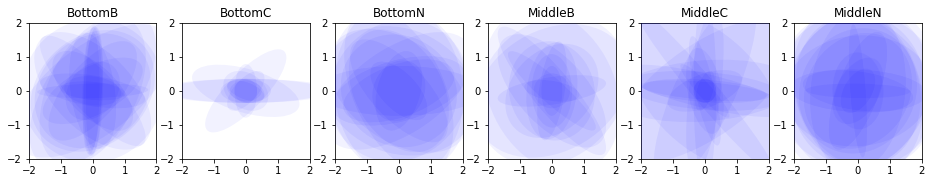

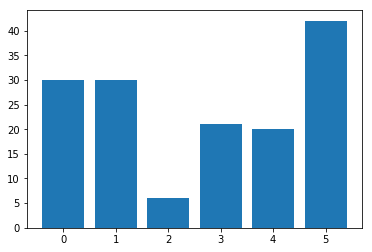

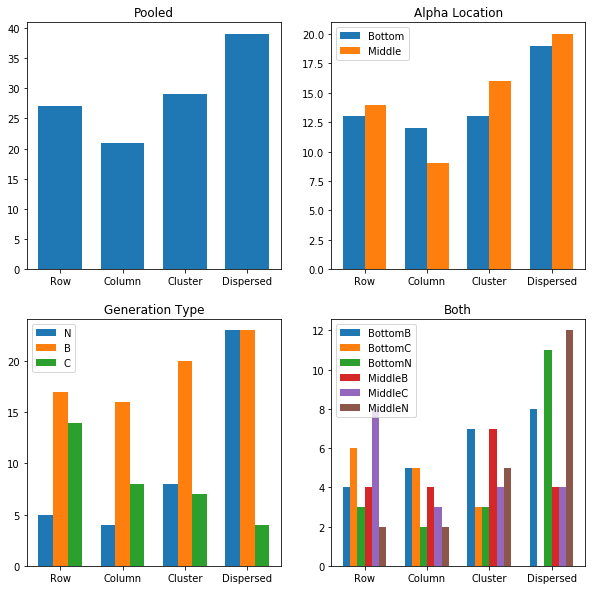

In [207]:
#Plot barcharts with empirical covs for comparison wit  eyeball chart and gmm chart
lim=2
gps = 1
corr_tol = .02 #correlation tolerance
spread_tol = .5 #spread tolerance
f, ax= plt.subplots(1,6, figsize=(16, 2.5))
means = np.zeros((1,2))
# cond_all = np.unique(list(data_all_ind.keys()))


               
types = {'Row':0,'Column':0,'Cluster':0,'DispersedP':0,'DispersedN':0,'Dispersed':0}
types2 = dict()#{'Row':0,'Column':0,'Cluster':0,'Dispersed':0}
pidlists = dict()
for i in range(2):
    for cni,cn in enumerate(cond_all):
    #     for gp in data_ind_all[cn]['traces'].keys():
        if cn[-1]!='C' and i>0:
            continue
        types2[cn] = {'Row':0,'Column':0,'Cluster':0,'Dispersed':0}
        for pid in data[cn].keys():
            ss = data[cn][pid][i+1]['cov'] 
            if np.abs(ss[0,1])<corr_tol:
                if ss[0,0]>spread_tol and ss[1,1]>spread_tol:
                    types['Dispersed'] +=1
                    types2[cn]['Dispersed'] += 1
                elif ss[0,0]<ss[1,1]:
                    types['Column'] += 1
                    types2[cn]['Column'] += 1
                else:
                    types['Row'] += 1
                    types2[cn]['Row'] += 1
            else:
                if np.max((ss[0,0],ss[1,1])) > spread_tol:
                    if ss[0,1]>0:
                        types['DispersedP'] += 1
                        types2[cn]['Dispersed'] += 1
                    else:
                        types['DispersedN'] += 1
                        types2[cn]['Dispersed'] += 1
                else:
                    types['Cluster'] += 1
                    types2[cn]['Cluster'] += 1
            plot_ellipse(ax[cni],means,[ss])
            ax[cni].set_ylim(-lim,lim)
            ax[cni].set_xlim(-lim,lim)
            ax[cni].set_title(cn)

#             print (ss[0,0],ss[0,1],ss[1,1])
#             print(ss_get)
#             print('%s %d-group:' % (cn,gps+1))
#             print(ss)
print(types)
typekey = np.unique(list(types.keys()))
typeval = [types[key] for key in typekey]
print(typeval)
plt.figure()
plt.bar(range(len(typeval)),typeval)

#Comparison plot
typekey = ['Row','Column','Cluster','Dispersed']
breakdown = ['Pooled','Alpha Location','Generation Type','Both']
breakdownCol = [['All'],conditionLabels,gentypeStr,cond_all]
# typekey = np.unique(list(types2.keys()))
space = .3
fig,axs = plt.subplots(2,2,figsize=(10,10))
typedata = dict()
for axi in range(len(breakdown)):
    cond_levels = breakdownCol[axi]
    for ci,keyi in enumerate(cond_levels):
        typedata[keyi] = dict()
        for tk in typekey:
            typedata[keyi][tk] = 0
            for cn in cond_all:
                if axi==0: #pooled                
                    typedata[keyi][tk] += types2[cn][tk]
                elif axi==1: #Alpha loc
                    if len(re.findall('\A%s'%keyi,cn)) > 0:
                        typedata[keyi][tk] += types2[cn][tk]
                elif axi==2: #Alpha loc
                    if len(re.findall('%s'%keyi,cn))>0:
                        typedata[keyi][tk] += types2[cn][tk]
                else:
                    if len(re.findall('%s'%keyi,cn))>0:
                        typedata[keyi][tk] = types2[cn][tk]
        width = (1 - space) / (len(cond_levels))
        xlim = range(1,len(typekey)+1)
        barx = [j - width*(len(cond_levels)-1)/2 + ci * width for j in xlim]
        typeval = [typedata[keyi][key] for key in typekey]
        ax = axs[np.unravel_index(axi,(2,2))]
        ax.bar(barx,typeval,width=width)
        ax.set_title(breakdown[axi])
        ax.set_xticklabels([''] + typekey)
        if axi>0:
            ax.legend(cond_levels,loc='upper left')



In [208]:
d

array([[ 0.375,  0.   ],
       [-0.375,  0.   ],
       [-0.625,  0.   ],
       [ 0.625,  0.   ]])